# Preprocessing
- Drop redundancies
- Handing missing values
- Encoding

In [36]:
import pandas as pd
import numpy as np

In [38]:
import pandas as pd
dataset = pd.read_excel('pharma.xlsx')

In [39]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 791679 entries, 0 to 791678
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Mã đơn hàng    721231 non-null  object        
 1   Mã KH          721231 non-null  object        
 2   Tên KH         721160 non-null  object        
 3   Tỉnh           709286 non-null  object        
 4   Quận/huyện     669461 non-null  object        
 5   Xã/phường      700076 non-null  object        
 6   Ngày           721231 non-null  datetime64[ns]
 7   SDT            721231 non-null  float64       
 8   Tên nhân viên  721231 non-null  object        
 9   Chi nhánh      721231 non-null  object        
 10  Mã thuốc       721231 non-null  object        
 11  Tên thuốc      721231 non-null  object        
 12  Đơn vị         721231 non-null  object        
 13  Số lượng       721231 non-null  float64       
 14  Đơn giá        721231 non-null  float64       
dtype

In [40]:
dataset.rename(columns={
    'Mã đơn hàng': 'orderID',
    'Mã KH': 'customerID',
    'Tên KH': 'customerName',
    'Tỉnh': 'province',
    'Quận/huyện': 'District',
    'Xã/phường': 'Ward/Commune',
    'Ngày ': 'time',
    'SDT': 'phone',
    'Tên nhân viên': 'employeeName',
    'Chi nhánh': 'branch',
    'Mã thuốc': 'drugID',
    'Tên thuốc': 'drugName',
    'Đơn vị': 'unit',
    'Số lượng': 'quantity',
    'Đơn giá': 'unitPrice'
}, inplace=True)


In [42]:
columns = dataset.columns
dataset.columns

Index(['orderID', 'customerID', 'customerName', 'province', 'District',
       'Ward/Commune', 'time', 'phone', 'employeeName', 'branch', 'drugID',
       'drugName', 'unit', 'quantity', 'unitPrice'],
      dtype='object')

In [43]:
number_unique = {}
for column in columns:
    number_unique[column] = dataset[column].nunique()
    print(f'{column}: {dataset[column].nunique()}')

orderID: 341939
customerID: 61808
customerName: 49183
province: 3800
District: 3707
Ward/Commune: 12389
time: 1351
phone: 1846
employeeName: 1714
branch: 4
drugID: 341
drugName: 457
unit: 10
quantity: 1453
unitPrice: 776


In [44]:
top = dataset['province'].value_counts()
top.head(20)

Thành phố Hà Nội         95736
Tỉnh Thanh Hóa           34058
Thành phố Hồ Chí Minh    33184
Tỉnh Nghệ An             30783
Tỉnh Thái Bình           29895
Tỉnh Thái Nguyên         27307
Thành phố Hải Phòng      26176
Thành phố Đà Nẵng        25161
Tỉnh Nam Định            24963
Tỉnh Quảng Ninh          17997
Tỉnh Hải Dương           16911
Tỉnh Tuyên Quang         16837
Tỉnh Vĩnh Phúc           16527
Tỉnh Bắc Ninh            16123
Tỉnh Hưng Yên            15117
Tỉnh Hà Nam              13976
Tỉnh Ninh Bình           13364
Tỉnh Bắc Giang           13168
Tỉnh Quảng Trị           12569
Tỉnh Phú Thọ             10934
Name: province, dtype: int64

## 1 Drop redundancies
- Drop columns with vast categories (numbers of unique)

### Case 1
- mã đơn hàng, mã kh, tên kh, tên nhân viên: drop vì
    - nunique lớn (nhiều thể loại)
    - 
- Dơn giá không liên quan vì = số lượng x giá (giá có thể thay đổi nhưng drop để đơn giản trong TH này)
- Tên thuốc dễ nhập sai -> giữ mã thuốc, bỏ tên thuốc, đơn vị
- địa điểm: chi nhánh, Tỉnh, quận/huyện, xã/phường -> chọn chi nhánh (drop còn lại)

In [45]:
drop_list = ['orderID', 'customerID', 'customerName', 'District',
       'Ward/Commune', 'employeeName', 'branch',
       'drugName', 'unit', 'unitPrice']
df1 = dataset.drop(drop_list, axis=1)
df1.head()

,province,time,phone,drugID,quantity
0,Thành phố Hà Nội,2018-10-04,983855018.0,G00817,50.0
1,Thành phố Hà Nội,2018-10-04,983855018.0,G00821,30.0
2,Thành phố Hà Nội,2018-10-04,983855018.0,P01191,200.0
3,Tỉnh Quảng Trị,2018-10-04,977519929.0,Z00209,400.0
4,Tỉnh Quảng Bình,2018-10-04,911561101.0,H00852,10.0


In [46]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 791679 entries, 0 to 791678
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   province  709286 non-null  object        
 1   time      721231 non-null  datetime64[ns]
 2   phone     721231 non-null  float64       
 3   drugID    721231 non-null  object        
 4   quantity  721231 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 30.2+ MB


In [47]:
# Step 1: Get the value counts
value_counts = df1['province'].value_counts()
type(value_counts)

pandas.core.series.Series

## 2. Choose top 7 popular city df_top7:
- Hà Nội, Thanh Hóa, Nghệ An, Thái Bình, Tp Hồ Chí Minh, Thái Nguyên, Thành phố Hải Phòng

In [49]:
# Step 2: Get the top 7 values
top_values = value_counts.nlargest(7).index.tolist()

# Step 3: Create a boolean mask for 7 locals
mask = df1['province'].isin(top_values)

# Step 4: Select the rows that contain the top 7 values
df_top7 = df1.loc[mask]
df_top7.province.nunique()
# type(df_top7)

7

## 3. Select top 8 popular drugs
- Step 1: Choose top 50 popular
- Step 2: Group by ATC code
- Step 3: Finish 

In [50]:
drug_50 = df_top7['drugID'].value_counts()
drug_50.head(50)
type(drug_50)

pandas.core.series.Series

In [86]:
top_8drug = drug_50.nlargest(50).index.tolist()

# Create a boolean mask for 50 drugID
mask1 = df_top7['drugID'].isin(top_8drug) 

df2 = df_top7.loc[mask1]


In [87]:
number_unique = {}
for column in df2.columns:
    number_unique[column] = df2[column].nunique()
    print(f'{column}: {df2[column].nunique()}')

province: 7
time: 1318
phone: 1070
drugID: 50
quantity: 701


 Create a new dataframe have 50 drugs at 7 locals ( include drugName)

In [88]:
# Merge df2 with df1 on 'province', 'phone', and 'drug ID'
df3 = pd.merge(df2, dataset[['province','time', 'phone', 'drugID', 'drugName', ]], on=['province','time', 'phone', 'drugID'], how='left')

# Rearrange the columns to put 'drug Name' last
df3 = df3[['province','time', 'phone', 'drugID', 'quantity', 'drugName']]


In [89]:
number_unique = {}
for column in df3.columns:
    number_unique[column] = df3[column].nunique()
    print(f'{column}: {df3[column].nunique()}')

province: 7
time: 1318
phone: 1070
drugID: 50
quantity: 701
drugName: 73


In [91]:
print(df3.drugID.unique())
# df3.drugName.unique()

['G00817' 'G00821' 'G00898' 'L00801' 'N00845' 'Z00200' 'Z00226' 'B01166'
 'H00852' 'Z00219' 'Z00197' 'G00869' 'C01842' 'M01076' 'D01063' 'Z00209'
 'M01090' 'P01146' 'M01225' 'D01183' 'A01303' 'D01304' 'P01299' 'T01701'
 'F00482' 'B01373' 'A01338' 'L00854' 'D01349' 'P01336' 'N01041' 'D01355'
 'N01080' 'D01375' 'T01855' 'P01364' 'T01864' 'G00951' 'F00550' 'R00365'
 'N01165' 'N01084' 'A01414' 'P01478' 'P01481' 'L00993' 'L01012' 'S01447'
 'H01921' 'M01656']


In [92]:
df3['day'] = df3['time'].dt.day
df3['month'] = df3['time'].dt.month
df3['quarter'] = df3['time'].dt.quarter
df3['year'] = df3['time'].dt.year

In [93]:
df3.province.unique()

array(['Thành phố Hà Nội', 'Tỉnh Thanh Hóa', 'Thành phố Hồ Chí Minh',
       'Tỉnh Nghệ An', 'Tỉnh Thái Nguyên', 'Tỉnh Thái Bình',
       'Thành phố Hải Phòng'], dtype=object)

In [94]:
data_month = df3.groupby([pd.to_datetime(df3['time']).dt.strftime('%Y-%m'), 'drugID'])['quantity'].sum().reset_index()
data_month.head(10)

,time,drugID,quantity
0,2018-10,B01166,800.0
1,2018-10,C01842,200.0
2,2018-10,D01063,400.0
3,2018-10,G00817,130.0
4,2018-10,G00821,630.0
5,2018-10,G00869,354.0
6,2018-10,G00898,1595.0
7,2018-10,H00852,40.0
8,2018-10,L00801,141.0
9,2018-10,M01076,80.0


In [95]:
pivot_month = pd.pivot_table(data_month, values='quantity', index='time', columns='drugID', aggfunc=np.sum)

In [97]:
pivot_month.head(2)

drugID,A01303,A01338,A01414,B01166,B01373,C01842,D01063,D01183,D01304,D01349,...,R00365,S01447,T01701,T01855,T01864,Z00197,Z00200,Z00209,Z00219,Z00226
time,,,,,,,,,,,,,,,,,,,,,
2018-10,NaN,NaN,NaN,800.0,NaN,200.0,400.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5330.0,11870.0,710.0,120.0,1380.0
2018-11,NaN,NaN,NaN,2200.0,NaN,2500.0,70.0,20.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,11003.0,47240.0,7100.0,1900.0,3750.0


## 4 Standardization, outlier

In [104]:
# Log transformed data
data0_std = np.log(pivot_month)
data0_std.describe()

drugID,A01303,A01338,A01414,B01166,B01373,C01842,D01063,D01183,D01304,D01349,...,R00365,S01447,T01701,T01855,T01864,Z00197,Z00200,Z00209,Z00219,Z00226
count,43.000000,34.000000,17.000000,46.000000,36.000000,46.000000,45.000000,44.000000,39.000000,33.000000,...,25.000000,10.000000,38.000000,30.000000,28.000000,46.000000,46.000000,46.000000,46.000000,46.000000
mean,7.625060,8.732989,7.189606,10.598989,11.092358,10.670121,6.891923,9.470938,9.894093,7.661446,...,9.572209,7.967048,7.735905,9.572695,8.168628,11.554419,12.578788,10.260621,10.643013,11.160327
std,0.745317,1.012860,1.508040,1.516037,1.074257,1.573315,1.431579,1.684899,1.733150,1.035243,...,0.672695,1.518276,1.122003,1.212348,1.529960,1.090789,1.200663,1.061506,1.480624,1.259261
min,6.234411,6.109248,2.302585,6.684612,7.580700,5.298317,4.248495,2.995732,4.605170,5.129899,...,7.414573,5.513429,5.525453,4.605170,2.995732,8.581107,9.381769,6.565265,4.787492,7.229839
25%,7.050055,8.240498,6.963190,9.538626,10.580596,9.442904,5.843544,8.706977,9.394782,6.815640,...,9.342245,7.219580,7.009633,9.036173,7.338130,10.866940,11.846222,9.614368,9.957327,10.228481
50%,7.495542,8.884025,7.550661,10.684998,11.260991,11.243165,7.148346,9.659282,10.234947,7.828436,...,9.590829,7.516527,7.881411,9.877369,8.652855,11.593813,12.437374,10.544499,10.818792,11.157779
75%,8.280068,9.463108,8.084562,11.704837,11.872824,11.776562,7.799753,10.487419,11.101058,8.364042,...,10.110095,8.657732,8.560173,10.179302,9.146716,12.400214,13.328126,10.916556,11.561227,12.163652
max,9.022323,10.257308,8.760923,13.315542,12.500152,12.838368,9.615605,12.536599,11.788282,9.194719,...,10.481785,10.551533,9.843791,11.425787,9.953230,13.390196,17.238302,11.664401,13.159120,13.124146


In [109]:
# fill NaN == 0
data0_std = data0_std.fillna(0)

# set threshold for number of zeros
threshold = 6

# drop columns with more than the threshold number of zeros
data1_std = data0_std.loc[:, (data0_std == 0).sum() <= threshold]
data1_std.describe()

drugID,A01303,B01166,C01842,D01063,D01183,G00817,G00821,G00869,G00898,H00852,M01076,M01090,M01225,N00845,Z00197,Z00200,Z00209,Z00219,Z00226
count,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000
mean,7.127773,10.598989,10.670121,6.742098,9.059158,7.460857,10.266194,9.444747,11.056141,7.876903,8.268922,8.214745,8.975363,13.111288,11.554419,12.578788,10.260621,10.643013,11.160327
std,2.035136,1.516037,1.573315,1.742542,2.554602,1.089136,1.089165,0.936711,1.742860,1.326635,1.251890,2.194572,2.336769,1.150199,1.090789,1.200663,1.061506,1.480624,1.259261
min,0.000000,6.684612,5.298317,0.000000,0.000000,4.867534,6.445720,5.869297,7.374629,3.401197,4.382027,2.302585,0.000000,9.740969,8.581107,9.381769,6.565265,4.787492,7.229839
25%,6.969907,9.538626,9.442904,5.801059,8.562774,6.835076,9.771938,8.929204,9.613334,7.235745,7.937771,7.036506,7.656967,12.196831,10.866940,11.846222,9.614368,9.957327,10.228481
50%,7.376341,10.684998,11.243165,7.139622,9.633635,7.861041,10.610890,9.587194,11.422381,8.189377,8.547718,8.676243,9.603925,13.054954,11.593813,12.437374,10.544499,10.818792,11.157779
75%,8.213522,11.704837,11.776562,7.797799,10.370867,8.181509,11.036821,10.106312,12.347117,8.636233,9.056761,9.900556,10.785012,14.065911,12.400214,13.328126,10.916556,11.561227,12.163652
max,9.022323,13.315542,12.838368,9.615605,12.536599,9.058005,11.649613,11.258072,13.560565,10.183011,10.213799,11.862948,11.871068,14.848873,13.390196,17.238302,11.664401,13.159120,13.124146


In [115]:
# Determine the criteria for identifying outliers, e.g., using IQR
Q1 = pivot_month.quantile(0.25)
Q3 = pivot_month.quantile(0.75)
IQR = Q3 - Q1
threshold = 1.5

# Calculate the number of outliers in each column
outliers = ((data1_std < (Q1 - threshold * IQR)) | (data1_std > (Q3 + threshold * IQR))).sum()
outliers
# Identify the columns that have more than 3 outliers
columns_to_drop = []
for col in outliers.index:
    if outliers[col] > 2:
        columns_to_drop.append(col)

# Drop the identified columns
data2_std = data1_std.drop(columns_to_drop, axis=1)
data2_std.describe()

C:\Users\luong\AppData\Local\Temp\ipykernel_21104\1335194123.py:8: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers = ((data1_std < (Q1 - threshold * IQR)) | (data1_std > (Q3 + threshold * IQR))).sum()
C:\Users\luong\AppData\Local\Temp\ipykernel_21104\1335194123.py:8: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers = ((data1_std < (Q1 - threshold * IQR)) | (data1_std > (Q3 + threshold * IQR))).sum()


drugID,A01303,B01166,C01842,D01063,D01183,G00817,G00821,G00869,G00898,H00852,M01076,M01090,M01225,N00845,Z00197,Z00200,Z00209,Z00219,Z00226
count,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000
mean,7.127773,10.598989,10.670121,6.742098,9.059158,7.460857,10.266194,9.444747,11.056141,7.876903,8.268922,8.214745,8.975363,13.111288,11.554419,12.578788,10.260621,10.643013,11.160327
std,2.035136,1.516037,1.573315,1.742542,2.554602,1.089136,1.089165,0.936711,1.742860,1.326635,1.251890,2.194572,2.336769,1.150199,1.090789,1.200663,1.061506,1.480624,1.259261
min,0.000000,6.684612,5.298317,0.000000,0.000000,4.867534,6.445720,5.869297,7.374629,3.401197,4.382027,2.302585,0.000000,9.740969,8.581107,9.381769,6.565265,4.787492,7.229839
25%,6.969907,9.538626,9.442904,5.801059,8.562774,6.835076,9.771938,8.929204,9.613334,7.235745,7.937771,7.036506,7.656967,12.196831,10.866940,11.846222,9.614368,9.957327,10.228481
50%,7.376341,10.684998,11.243165,7.139622,9.633635,7.861041,10.610890,9.587194,11.422381,8.189377,8.547718,8.676243,9.603925,13.054954,11.593813,12.437374,10.544499,10.818792,11.157779
75%,8.213522,11.704837,11.776562,7.797799,10.370867,8.181509,11.036821,10.106312,12.347117,8.636233,9.056761,9.900556,10.785012,14.065911,12.400214,13.328126,10.916556,11.561227,12.163652
max,9.022323,13.315542,12.838368,9.615605,12.536599,9.058005,11.649613,11.258072,13.560565,10.183011,10.213799,11.862948,11.871068,14.848873,13.390196,17.238302,11.664401,13.159120,13.124146


In [124]:
data2_std.columns.nunique()

19

## 5 EDA

IndexError: list index out of range

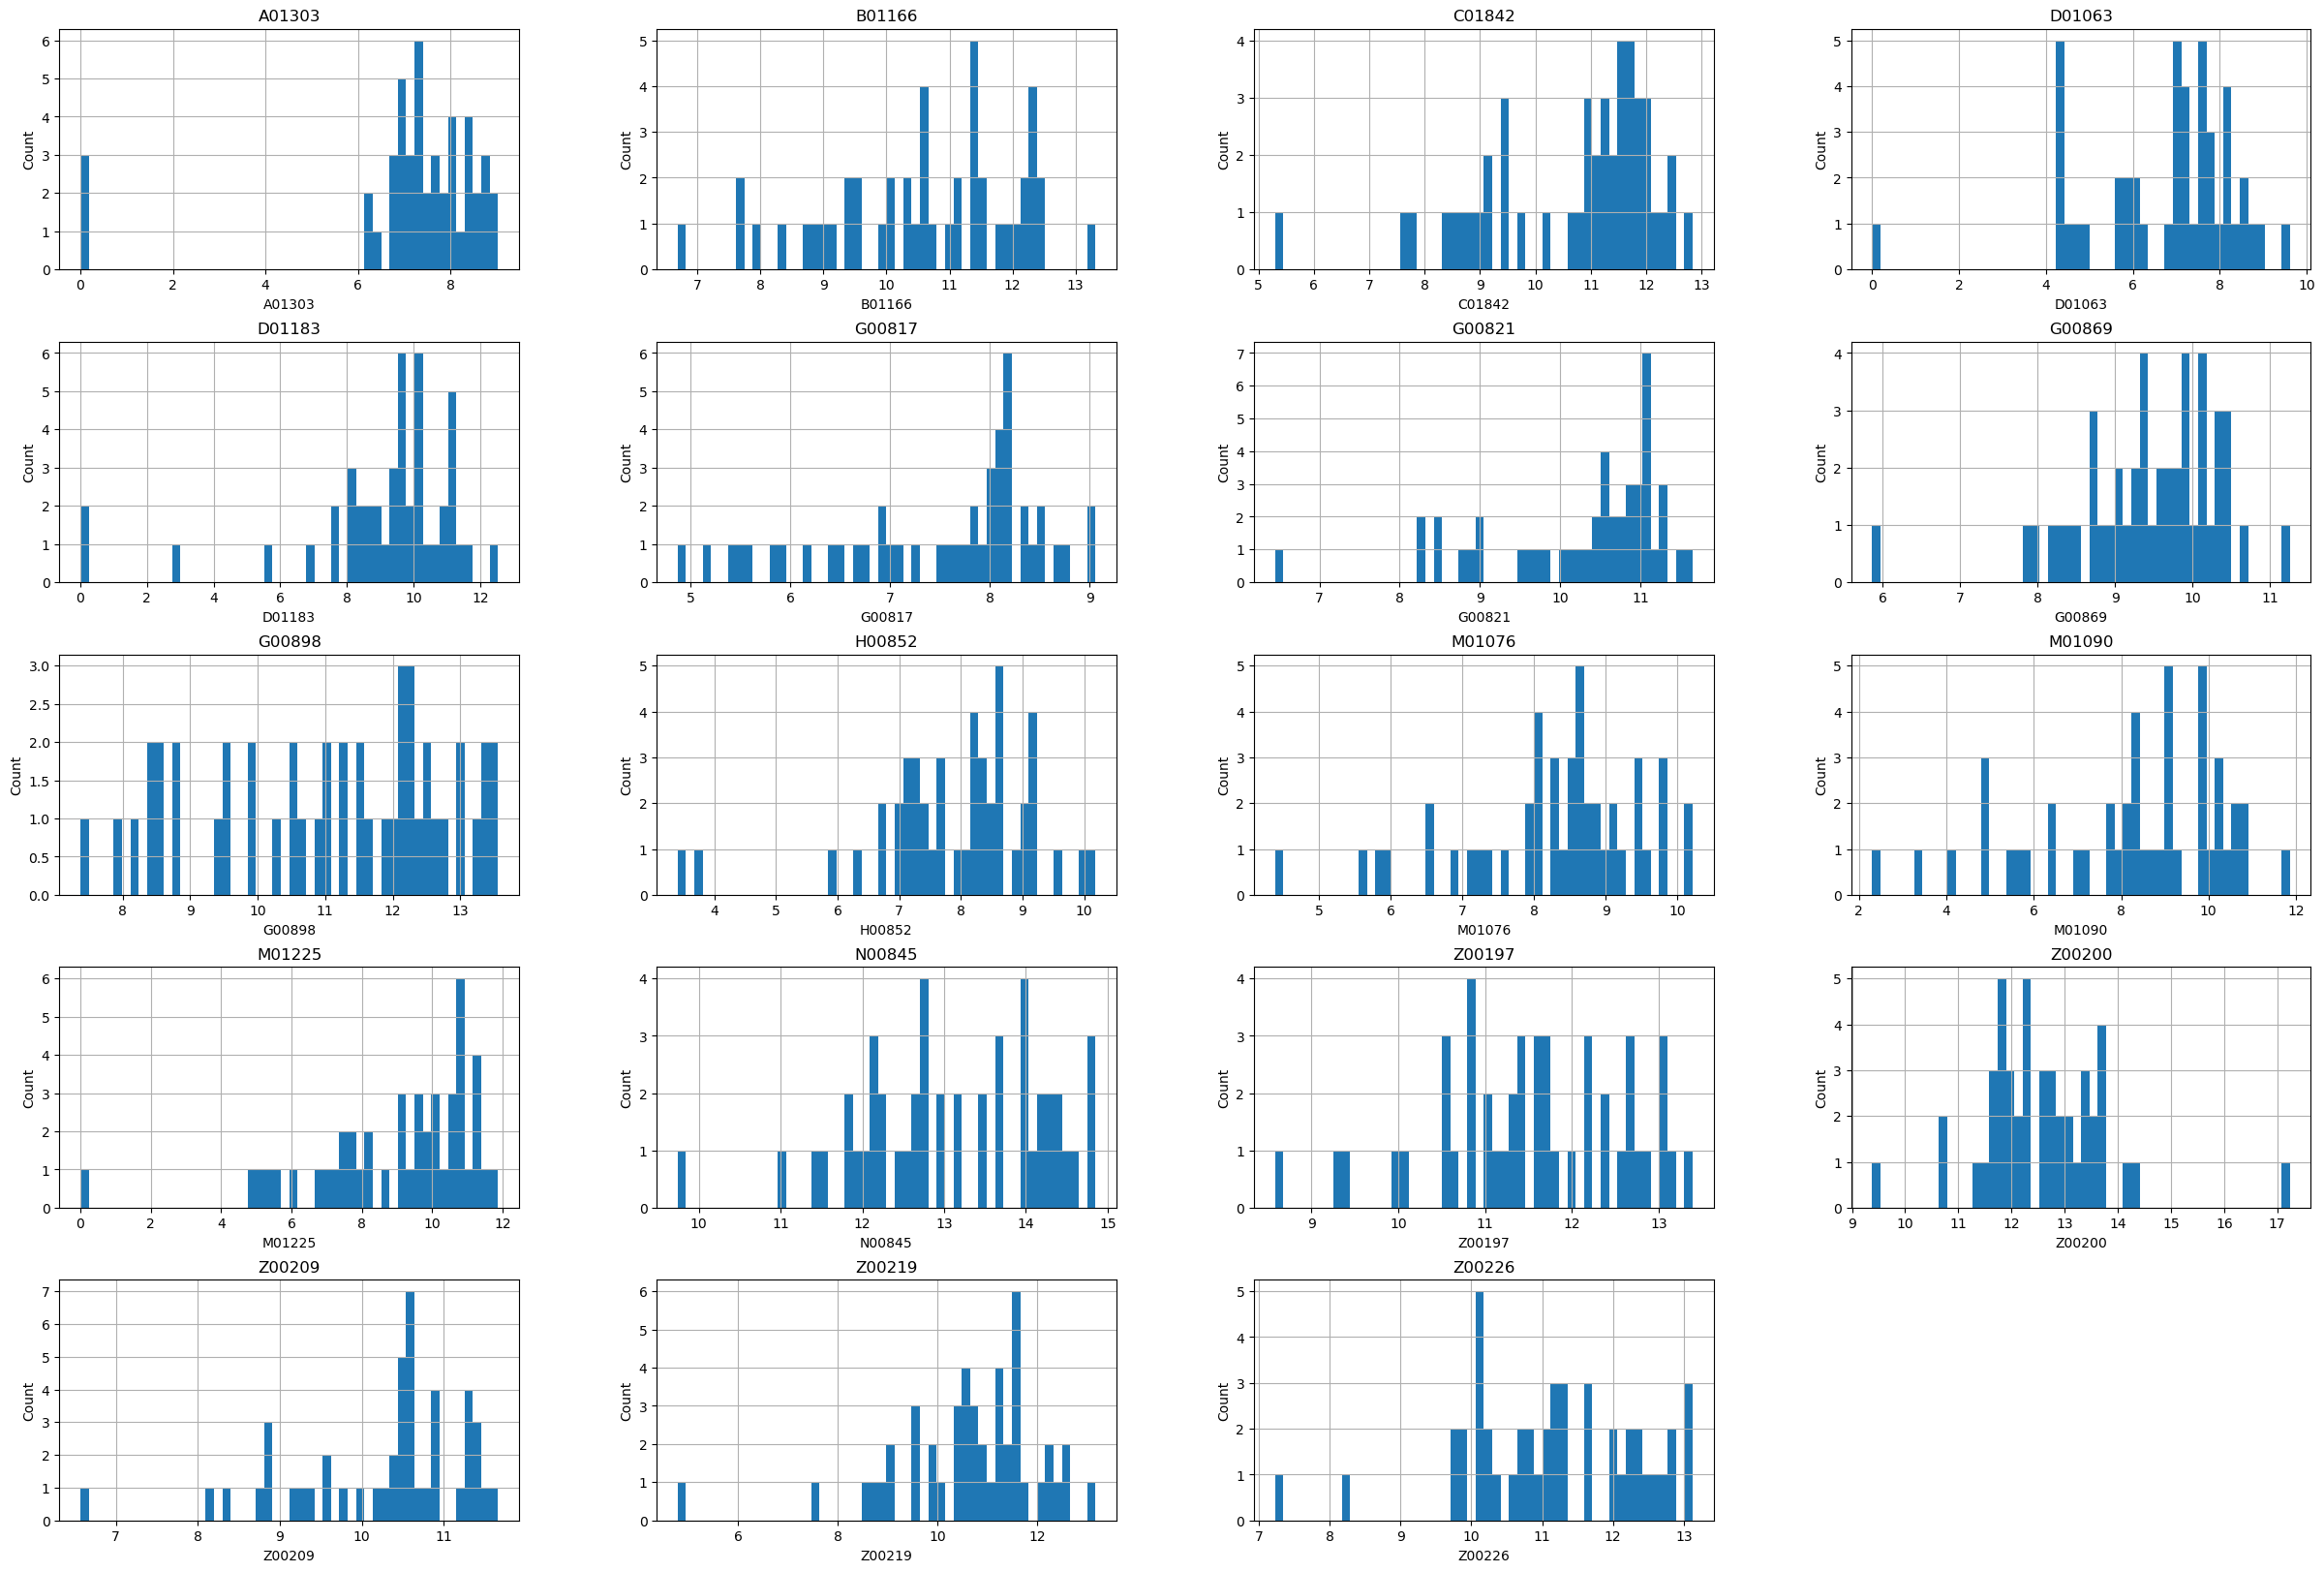

In [120]:
import seaborn as sns
xlbl = ['A01303', 'B01166', 'C01842', 'D01063', 'D01183', 'G00817', 'G00821',
       'G00869', 'G00898', 'H00852', 'M01076', 'M01090', 'M01225', 'N00845',
       'Z00197', 'Z00200', 'Z00209', 'Z00219', 'Z00226']
axarr = data2_std.hist(bins=50, figsize=(30, 20)) # histograms of dataframe variables
for idx, ax in enumerate(axarr.flatten()):
    ax.set_xlabel(xlbl[idx])
    ax.set_ylabel("Count")
plt.show()

In [122]:
import matplotlib.pyplot as plt
dt = data2_std.set_index('A01303')

Text(0.5, 1.0, 'Drug Consumption Over Time')

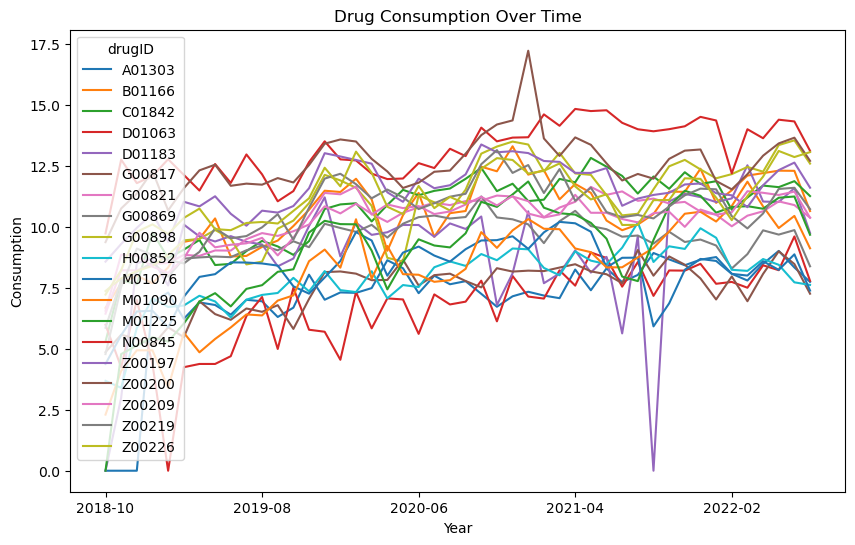

In [123]:
ax = data2_std.plot(kind='line', figsize=(10, 6))

# set axis labels and chart title
ax.set_xlabel('Year')
ax.set_ylabel('Consumption')
ax.set_title('Drug Consumption Over Time')

In [132]:
data2_std.columns.unique()

Index(['A01303', 'B01166', 'C01842', 'D01063', 'D01183', 'G00817', 'G00821',
       'G00869', 'G00898', 'H00852', 'M01076', 'M01090', 'M01225', 'N00845',
       'Z00197', 'Z00200', 'Z00209', 'Z00219', 'Z00226'],
      dtype='object', name='drugID')

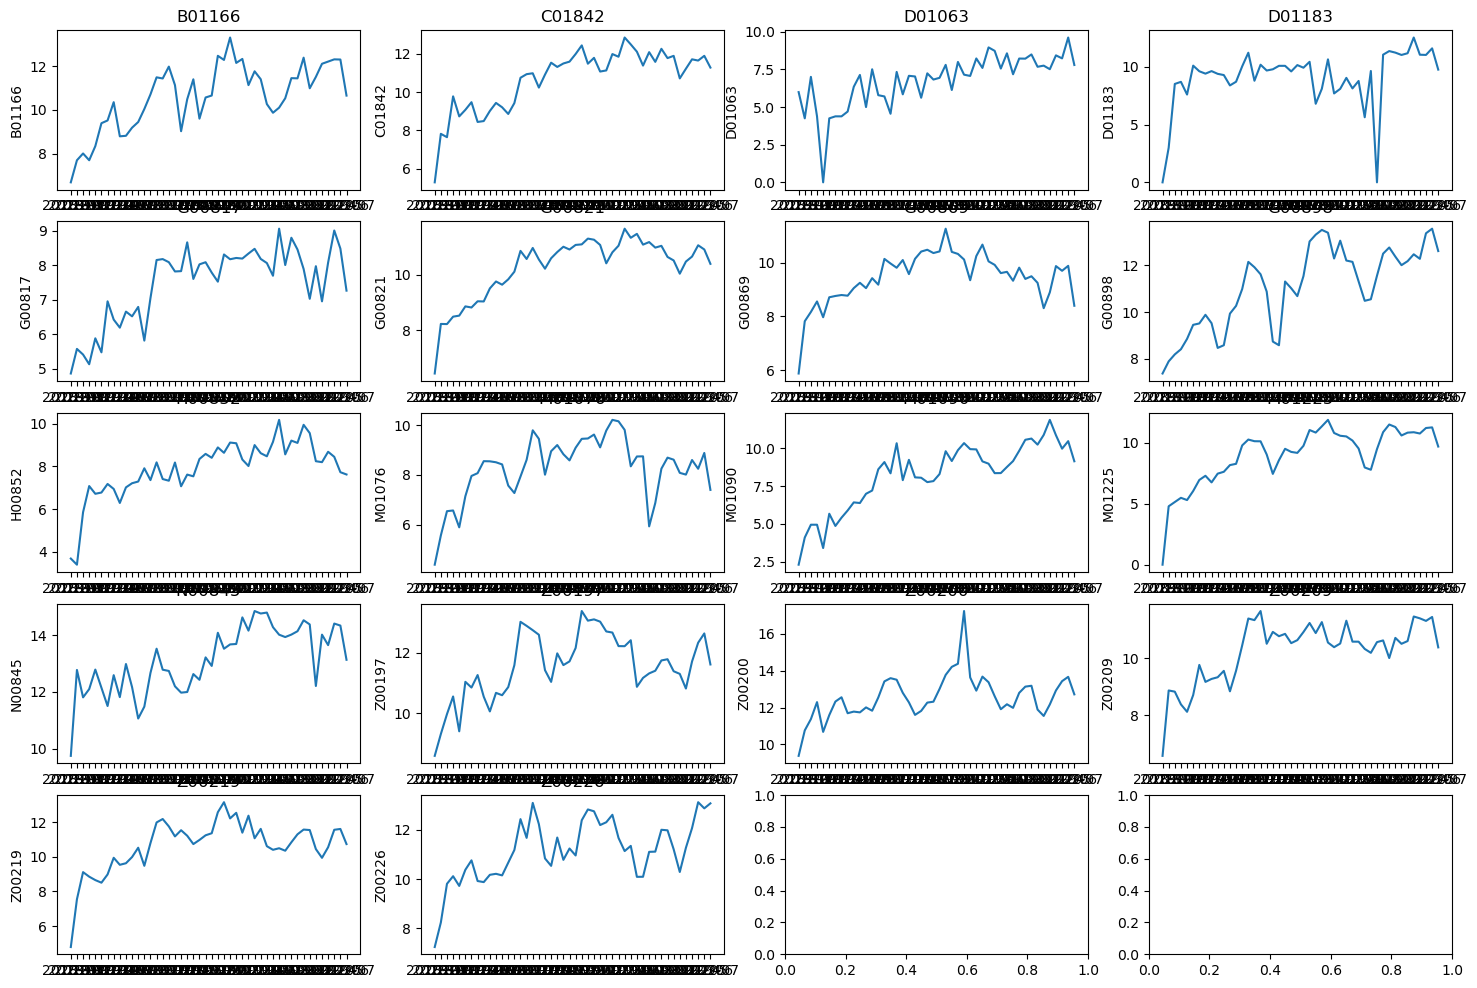

In [139]:
# Define the number of rows and columns for subplots
num_rows = 5
num_cols = 4

# Create a figure with subplots
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(18,12))

# Flatten the axs array
axs = axs.flatten()
# ticks = data2_std['index'][::6].tolist()


# Loop through each drug column and plot it on a separate subplot
for i, drug in enumerate(data2_std.columns[1:]):
    sns.lineplot(x='time', y=drug, data=data2_std, ax=axs[i])
    axs[i].set_title(drug)
    # axs[i].set_xticks(ticks)
    axs[i].set_xlabel('')

